# Introduction 

This file generates a Gaussian Process regressor (GPR) for the analytical function presentd in the Scikit-Learn documentation, using the following GPR libraries, in order to compare their results: 
- Scikit Learn: `GaussianProcessRegressor`, which uses an `lbfgs`optimizer
- GPyTorch: using the PyTorch `Adam` optimizer
- GPyTorch: using an PyTorch `lbfgs` optimizer

The analytical function used in this example was obtained from the **Scikit-Learn** Gaussian Process regression documentation's [basic_introductory_example](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html). 

All GPRs are trained considering an optimizable **noise** hyperparameter



### Import Libraries

In [1]:
 
try:
    import sys
    import os
    import time
    import logging
    import math
except ModuleNotFoundError as e:
    print('ModuleNotFoundError: Missing basic libraries (required: sys, os, pickle, glob, time, logging, math,'
          ' itertools')
    print(e)
    
try:
    # General libraries
    import numpy as np
    import matplotlib.pyplot as plt
    import scipy.stats as stats
    # For Scikit Learn: 
    import sklearn.gaussian_process.kernels
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF
    # For GPytorch libraries: 
    import torch
    import gpytorch
except ModuleNotFoundError as e:
    print('ModuleNotFoundError: Missing additional libraries (required: numpy, pandas, matplotlib, seaborn,'
          ' scipy.stats, tqdm')
    print(e)


Input variables

In [2]:
test_size = 10_000  # Number of test data samples
train_size = 20     # number of training pairs to use 

random_sampling = True  # True: randomly samples parameter sets, False: samples at equally-spaced intervals) 

## Generate training data. 
The training data, input-output pairs, used to train the GPR model will be the same for all libraries being tested, such that the results can be comparable.

 The input parameter [data] is 1D (one parameter per set). Here, we generate the training and testing input parameter sets. 

In [3]:
if random_sampling:
     test_data = np.random.uniform(0, 10, (test_size, 1))
     train_data = np.random.uniform(0, 10, (train_size, 1))

     test_data = np.sort(test_data, axis=0)  # ordered parameter values
else: 
     test_data = np.linspace(0, 10, test_size).reshape(-1, 1)
     train_data = np.linspace(0, 10, train_size).reshape(-1, 1)

# train_data = np.array([[0.5], [1.6], [2.2], [2.5], [3.4], [6.8], [8.6]])


The data is generated by the following analytical function, which takes 1 parameter as sole input, and returns a single output value, such that we have a 1D-input, 1D-output space: $$y = \omega \cdot sin(omega),$$ where the parameter follows a Uniform distribution U[0,10]. We obtain a reference data set by evaluating the function in the `test_data` set. 

We generate noisy training data by evaluating the `train_data` in the function and adding noise to it: $$y = \omega \cdot sin(\omega) + \mathcal{N}(0, 1) $$. 

In [4]:
reference_y = test_data * np.sin(test_data)
train_y = train_data * np.sin(train_data) + np.random.normal(size=(train_size, 1))

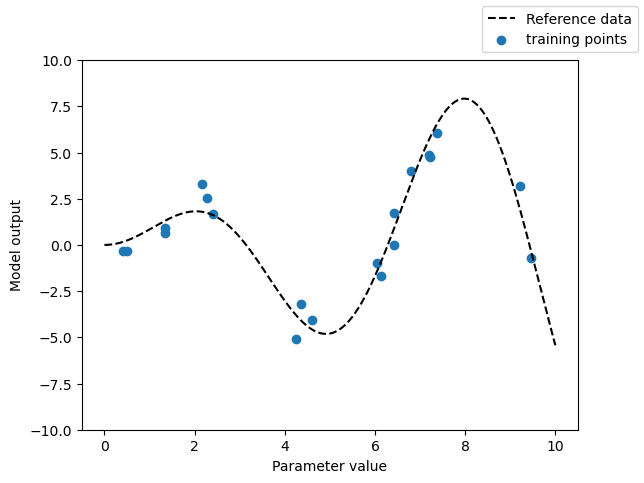

In [5]:
# Plot training data: 
fig, ax = plt.subplots()
ax.plot(test_data, reference_y, label="Reference data", linestyle="dashed", color='black')
ax.scatter(train_data, train_y, label='training points')
ax.set_ylim(-10, 10)
ax.set_xlabel('Parameter value')
ax.set_ylabel('Model output')
fig.legend()
plt.show()

## Scikit-Learn GPR Library

### Set up the model. 

We create a `GaussianProcessRegressor` with an additive kernel, consisting of an `RBF` kernel and a `WhiteNoise` kernel, whose initial noise level is set as:  $$\frac{\sigma_{train_y}}{\sqrt{2}}.$$ The `WhiteKernel` is responsible for accounting for noise present in the training data.  

In [6]:
kernel = sklearn.gaussian_process.kernels.ConstantKernel(1) * RBF() + sklearn.gaussian_process.kernels.WhiteKernel(noise_level=np.std(train_y)/np.sqrt(2))
gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=10)

### Train and Evaluate GPR

We then train a GPR using the training data and the `fit` function. We then evaluate it on the test data using the `predict` function. For the `predict` function, we set the option `return_std=True` to obtain the mean and standard deviation of the surrogate predictions. 

In [7]:
gpr.fit(train_data, train_y)
surrogate_prediction_skl, surrogate_std_skl = gpr.predict(test_data, return_std=True)
print(surrogate_prediction_skl)

# Calculate upper and lower 95% confidence intervals, for plotting purposes. 
lower_skl = surrogate_prediction_skl - (1.96 * surrogate_std_skl)
upper_skl = surrogate_prediction_skl + (1.96 * surrogate_std_skl)

[-0.30975848 -0.3097994  -0.30983991 ... -1.11645545 -1.12357103
 -1.12503786]


To compare the results with the other libraries, we save the values of the hyperparameters, including: [`constant`, `lengthscale`, `noise`]

In [8]:
hp_skl = np.exp(gpr.kernel_.theta)  # [constant^2 (variance), correlation length and noise]
print(f'For the Scikit-Learn library, the GPR hyperparameters are: \n Constant: {math.sqrt(hp_skl[0])}     Lengthscale: {hp_skl[1]}     noise: {hp_skl[2]}')

For the Scikit-Learn library, the GPR hyperparameters are: 
 Constant: 1.1665541153660575     Lengthscale: 1.1927408563291197     noise: 0.09862694960923657


We plot the GPR generated using the Scikit-Learn library. 

In [9]:
# Function to plot GPR, reused for all libraries. 
def plot_gpr(gpr_x, gpr_y, conf_int_lower, conf_int_upper, tp_x, tp_y, method, analytical=None, hyper_param = None):
    """
        Plots the final GPE, including GPE predictions and all BAL-selected training points and confidence intervals.

        Parameters
        ----------
        :param gpr_x: np.array [mc_size, 1], parameter values where GPE was evaluated (X)
        :param gpr_y: np.array [N.Obs, mc_size], GPE prediction values (Y)
        :param conf_int_lower: np.array [N.obs, mc_size], 95% lower confidence intervals for each gpr_y from GPE
        :param conf_int_upper: np.array [N.obs, mc_size], 95% upper confidence intervals for each gpr_y from GPE
        :param tp_x: np.array [#tp+1, 1], parameter values from training points
        :param tp_y: np.array [#tp+1, N.Obs], forward model outputs at tp_x
        :param true_y: np.array [1, N.Obs] Y value of the observation value
        :param method: string, with name of Library/optimizer used. 
        :param analytical: np.array [1, mc_size], y values evaluated in forward model,  or None (to not plot it)
        :param hyper_param: np.array[3, ], with 1D GPR hyperparameters [variance, correlation length, noise]
        """

    fig, ax = plt.subplots(dpi=100)

    lims_gpr = np.array([math.floor(np.min(conf_int_lower)), math.ceil(np.max(conf_int_upper))])
    # Get limits
    lims_x = [math.floor(np.min(gpr_x)), math.ceil(np.max(gpr_x))]

    if analytical is not None:
        # Analytical limits
        lims_an = np.array([math.floor(np.min(analytical)), math.ceil(np.max(analytical))])
        # Max limit is defined by gpr and analytical
        lims_y = [np.min(np.array([lims_gpr[0], lims_an[0]])), np.max(np.array([lims_gpr[1], lims_an[1]]))]
    else:
        lims_y = lims_gpr

    # GPE data ---------------------------------------------------------------
    data = np.vstack((gpr_x.T, gpr_y.T, conf_int_lower, conf_int_upper))
    gpr_data = data[:, data[0, :].argsort()]

    ax.plot(gpr_data[0, :], gpr_data[1, :], label="GPE mean", linewidth=2, color='b', zorder=1)
    ax.fill_between(gpr_data[0, :].ravel(), gpr_data[2, :], gpr_data[3, :], alpha=0.5,
                          label=r"95% confidence interval")

    # Training points ---------------------------------------------------------------------

    ax.scatter(tp_x, tp_y, label="Train", color="blue", zorder=2)  # s=500
        
    # Plot analytical data
    if analytical is not None:
        ax.plot(gpr_x, analytical, color='k', linewidth=2, linestyle="dashed", label="f(x)", zorder=1)

    # Legends
    handles, labels = ax.get_legend_handles_labels()

    # Set limits --------------------------------------------------------------------------------
    ax.set_xlim(lims_x)
    ax.set_ylim([lims_y[0] - (0.5 * (lims_y[1] - lims_y[0])), lims_y[1] * 1.1])


    ax.set_xlabel("Parameter value")
    ax.set_ylabel("Output")
        
    fig.suptitle(f'GPR: {method}')
    plt.subplots_adjust(top=0.92, bottom=0.18, wspace=0.3, hspace=0.3)

    if hyper_param is not None: 
        ax.text(1, -10, f'Constant: {round(hyper_param[0], 3)}')
        ax.text(1, -11.5, f'Correlation length: {round(hyper_param[1], 3)}')
        ax.text(1, -13, f'Noise: {round(hyper_param[2], 3)}')
    fig.legend(handles, labels, loc='lower center', ncol=5)
    plt.show(block=False)

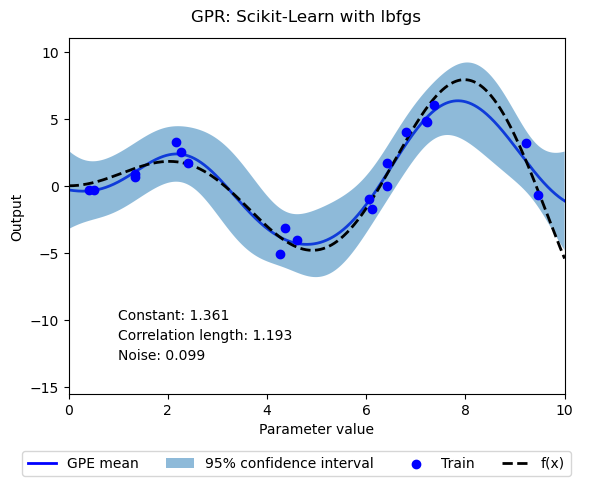

In [10]:
plot_gpr(test_data, surrogate_prediction_skl, lower_skl, upper_skl, train_data, train_y, method="Scikit-Learn with lbfgs ", analytical=reference_y, hyper_param=hp_skl)

## GPyTorch with Adam Optimizer

We generate a GPR using the GPyTorch library and the `Adam` optimizer included in Pytorch. 

### Generate training data 
 As a first step, we must transform the test and training data (which are in numpy format) to *tensors*, to be used in PyTorch. 

In [11]:
train_data_tensor = torch.tensor(train_data).float()
train_y_tensor = torch.tensor(train_y[:,0]).float()

test_data_tensor = torch.tensor(test_data).float()

### Set up GPR model

We will build a GPR model using the following objects from the GPYTorch Library: 
- GP model:  `ExactGP`
- Likelihood: `GaussianLikelihood` 
- Kernel: `ScaleKernel(RBFKernel)`
- prior mean: `ConstantMean`

In [12]:
# Build a class instance that inherits the "ExactGP" class from GPyTorch. The user-built class receives, therough the __init__ function the training data, the likelihood and the kernel and 
# assigns them to class attributes. This class will be recycled for all GPyTorch applications. 

class MyExactGPModel(gpytorch.models.ExactGP):

    def __init__(self, train_x, train_y, likelihood, kernel):
        super(MyExactGPModel, self).__init__(train_inputs=train_x, train_targets=train_y, likelihood=likelihood)
        # self.mean_module = gpytorch.means.ConstantMean()
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = kernel

    def forward(self, x):
        """
        Takes in the training data (x) and returns a multivariate normal distribution with mean and covariance (kernel)
        set in "__init__()"
        :param x: training data (parameter sets)
        """
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [13]:
# Initiate the likelihood and GPR model: 

likelihood = gpytorch.likelihoods.GaussianLikelihood()                # Initiated with default values for noise --> Can also be initiated as with scikit learn
# likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-6))   # Option to modify noise limits (as with Scikit learn)
# likelihood.noise = np.std(y_model)/np.sqrt(2)                         # Option to initialize noise value, as with Scikit-Learn. 

kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())   # Initiated with default values for constant and lengthscale
# model.covar_module.base_kernel.lengthscale = 1                      # Option to initialize the lengthscale value 

gpmodel = MyExactGPModel(train_data_tensor, train_y_tensor, likelihood, kernel)
# gpmodel.covar_module.outputscale = 1                                             # Option to initialize output scale
stop=1

### Train GPR: Adam optimizer

For the first implementation using GPyTorch, we train the GPR by optimizing the hyperparameters using the PyTorch `Adam` optimizer. 

In [14]:
# Initialize train mode: 
gpmodel.train()
likelihood.train()
training_iter = 50  # Can be modified to see how it affects behavior of optimization

# Setup Adam optimizer: 
optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.1)  # Learning rate can be modified by the user, to see it's effect on the convergence of hyperparamters. 

# Setup loss function: 
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gpmodel)

# Optimize parameters:
for j in range(training_iter):
    # a. Zero gradients from previous iterarion
    optimizer.zero_grad()
    # b. Output from model
    output = gpmodel(train_data_tensor)
    # c. Calculate loss and back propagation gradients
    loss = -mll(output, train_y_tensor)
    loss.backward()
    # with torch.no_grad():
    #     hp = model.covar_module.base_kernel.lengthscale.numpy()
    print(
        f'Iter {j + 1}/{training_iter} - Loss: {loss.item()}   Outputscale: {gpmodel.covar_module.outputscale.item()}   lengthscale: {gpmodel.covar_module.base_kernel.lengthscale.item()}    noise: {gpmodel.likelihood.noise.item()}')
    optimizer.step()

Iter 1/50 - Loss: 3.046821117401123   Outputscale: 0.6931471824645996   lengthscale: 0.6931471824645996    noise: 0.6932471990585327
Iter 2/50 - Loss: 2.9354023933410645   Outputscale: 0.7443966269493103   lengthscale: 0.6443967223167419    noise: 0.7444967031478882
Iter 3/50 - Loss: 2.8402504920959473   Outputscale: 0.7979117035865784   lengthscale: 0.6023814082145691    noise: 0.7978413105010986
Iter 4/50 - Loss: 2.7584681510925293   Outputscale: 0.8534950017929077   lengthscale: 0.5746238827705383    noise: 0.8529422283172607
Iter 5/50 - Loss: 2.6863512992858887   Outputscale: 0.9109235405921936   lengthscale: 0.5650478005409241    noise: 0.9094238877296448
Iter 6/50 - Loss: 2.622143507003784   Outputscale: 0.9699517488479614   lengthscale: 0.5689118504524231    noise: 0.966875433921814
Iter 7/50 - Loss: 2.5653979778289795   Outputscale: 1.0303186178207397   lengthscale: 0.5809940099716187    noise: 1.0248562097549438
Iter 8/50 - Loss: 2.5157203674316406   Outputscale: 1.09175693988

### Evaluate GPR



Print results using GPyTorch library and PyTorch-built-in `Adam` optimizer. 

In [15]:
# Initialize evaluation mode: 
gpmodel.eval()
likelihood.eval()

# Evaluate in test data: 
with torch.no_grad(), gpytorch.settings.fast_pred_var():
     # Evaluate GPR
     f_preds = likelihood(gpmodel(test_data_tensor))
     # Extract  mean and variance to numpy array. 
     surrogate_prediction_adam = f_preds.mean.numpy()
     surrogate_std_adam= f_preds.variance.numpy()

     # Estimate and extract 95% confidence intervals: 
     lower, upper = f_preds.confidence_region()
     upper_adam = upper.numpy()
     lower_adam = lower.numpy()

     # Save hyperparameter values:   
     hp_adam = np.zeros(3)  # [constant^2 (variance), correlation length and noise]
     hp_adam[0] = gpmodel.covar_module.outputscale.numpy()
     hp_adam[1] = gpmodel.covar_module.base_kernel.lengthscale.numpy()[0, :]
     hp_adam[2] = gpmodel.likelihood.noise.numpy()
     print(round(hp_adam[1], 3))
     print(f'For the GPyTorch library with Adam optimizer, the GPR hyperparameters are: \n Constant: {math.sqrt(hp_adam[0])}     Lengthscale: {hp_adam[1]}     noise: {hp_adam[2]}')

0.795
For the GPyTorch library with Adam optimizer, the GPR hyperparameters are: 
 Constant: 1.763298595040618     Lengthscale: 0.7945104241371155     noise: 1.4760257005691528


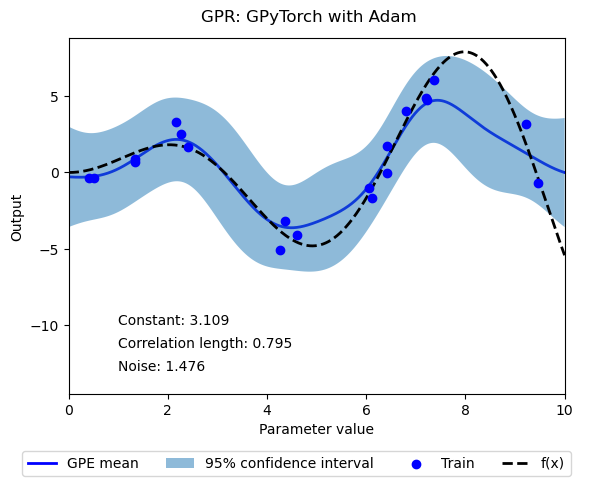

In [16]:
plot_gpr(test_data, surrogate_prediction_adam, lower_adam, upper_adam, train_data, train_y, method= "GPyTorch with Adam", analytical=reference_y, hyper_param=hp_adam) 

### Results

## GPyTorch with lbfgs optimizer

We generate a GPR using the GPyTorch library, using a PyTorch-based `lbfgs`. 

### Generate training data 

We use the same training data generated in the previous section. 

### Set up GPR model

We will build a GPR model using the following objects from the GPYTorch Library: 
- GP model:  `ExactGP`
- Likelihood: `GaussianLikelihood` 
- Kernel: `ScaleKernel(RBFKernel)`
- prior mean: `ConstantMean`

In [17]:
# Initiate the likelihood and GPR model: 

likelihood = gpytorch.likelihoods.GaussianLikelihood()                # Initiated with default values for noise --> Can also be initiated as with scikit learn
# likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-6))   # Option to modify noise limits (as with Scikit learn)
# likelihood.noise = np.std(train_y)/np.sqrt(2)                         # Option to initialize noise value, as with Scikit-Learn.

# Fixed noise: 
# ns = torch.ones(1) * 1e-7 
# likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=ns)

kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())   # Initiated with default values for constant and lengthscale
# model.covar_module.base_kernel.lengthscale = 1                      # Option to initialize the lengthscale value 

gpmodel = MyExactGPModel(train_data_tensor, train_y_tensor, likelihood, kernel)
# gpmodel.covar_module.outputscale = 1                                             # Option to initialize output scale

In [18]:
# Initialize train mode: 
gpmodel.train()
likelihood.train()
training_iter = 50  # Can be modified to see how it affects behavior of optimization

# Setup LBFGS optimizer: 
optimizer = torch.optim.LBFGS(gpmodel.parameters(), lr=0.1)  # Learning rate can be modified by the user, to see it's effect on the convergence of hyperparamters. 

# Setup loss function: 
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gpmodel)

def closure():
    optimizer.zero_grad()
    output = gpmodel(train_data_tensor)
    loss = -mll(output, train_y_tensor)
    loss.backward()
    return loss

# Optimize parameters:
for j in range(training_iter):
    # a. Zero gradients from previous iterarion
    optimizer.step(closure)
    loss = closure()
    print(
        f'Iter {j + 1}/{training_iter} - Loss: {loss.item()}   Outputscale: {gpmodel.covar_module.outputscale.item()}   lengthscale: {gpmodel.covar_module.base_kernel.lengthscale.item()}    noise: {gpmodel.likelihood.noise.item()}')


Iter 1/50 - Loss: 2.1379616260528564   Outputscale: 2.572646141052246   lengthscale: 0.7542862296104431    noise: 0.8351637125015259
Iter 2/50 - Loss: 1.9674640893936157   Outputscale: 5.895038604736328   lengthscale: 0.9615724086761475    noise: 0.8892031908035278
Iter 3/50 - Loss: 1.9385849237442017   Outputscale: 9.704367637634277   lengthscale: 1.1113090515136719    noise: 0.8651610016822815
Iter 4/50 - Loss: 1.9362480640411377   Outputscale: 11.700972557067871   lengthscale: 1.1926170587539673    noise: 0.8629533052444458
Iter 5/50 - Loss: 1.9361827373504639   Outputscale: 12.074132919311523   lengthscale: 1.2073261737823486    noise: 0.8625228404998779
Iter 6/50 - Loss: 1.9361793994903564   Outputscale: 12.137040138244629   lengthscale: 1.2097182273864746    noise: 0.8624470233917236
Iter 7/50 - Loss: 1.936178207397461   Outputscale: 12.15712833404541   lengthscale: 1.2105059623718262    noise: 0.8624158501625061
Iter 8/50 - Loss: 1.9361774921417236   Outputscale: 12.175387382507

In [19]:
# Initialize evaluation mode: 
gpmodel.eval()
likelihood.eval()

# Evaluate in test data: 
with torch.no_grad(), gpytorch.settings.fast_pred_var():
     # Evaluate GPR
     f_preds = likelihood(gpmodel(test_data_tensor))
     # Extract  mean and variance to numpy array. 
     surrogate_prediction_lbfgs = f_preds.mean.numpy()
     surrogate_std_lbfgs= f_preds.variance.numpy()

     # Estimate and extract 95% confidence intervals: 
     lower, upper = f_preds.confidence_region()
     upper_lbfgs = upper.numpy()
     lower_lbfgs = lower.numpy()

     # Save hyperparameter values:   
     hp_lbfgs = np.zeros(3)  # [constant^2 (variance), correlation length and noise]
     hp_lbfgs[0] = gpmodel.covar_module.outputscale.numpy()
     hp_lbfgs[1] = gpmodel.covar_module.base_kernel.lengthscale.numpy()[0, :]
     hp_lbfgs[2] = gpmodel.likelihood.noise.numpy()
     print(round(hp_lbfgs[1], 3))
     print(f'For the GPyTorch library with LBFGS optimizer, the GPR hyperparameters are: \n Constant: {math.sqrt(hp_lbfgs[0]):0.3f}     Lengthscale: {hp_lbfgs[1]:0.3f}     noise: {hp_lbfgs[2]:0.3f}')

1.212
For the GPyTorch library with LBFGS optimizer, the GPR hyperparameters are: 
 Constant: 3.492     Lengthscale: 1.212     noise: 0.862


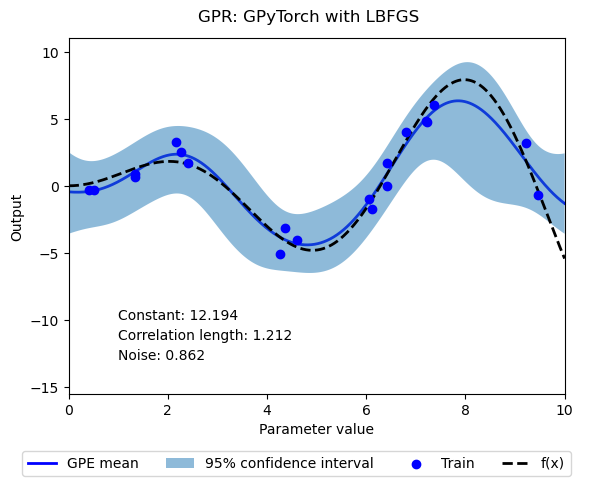

In [20]:
plot_gpr(test_data, surrogate_prediction_lbfgs, lower_adam, upper_lbfgs, train_data, train_y, method= "GPyTorch with LBFGS", analytical=reference_y, hyper_param=hp_lbfgs) 

## Comparison


In [21]:
print(f'For the <Scikit-Learn> library with an <lbfgs> optimizer, the GPR hyperparameters are: \n Constant: {round(math.sqrt(hp_skl[0]),3)}     Lengthscale: {round(hp_skl[1],3)}     noise: {round(hp_skl[2],3)} \n')
print(f'For the <GPyTorch> library with an <Adam> optimizer, the GPR hyperparameters are: \n Constant: {round(math.sqrt(hp_adam[0]),3)}     Lengthscale: {round(hp_adam[1],3)}     noise: {round(hp_adam[2],3)} \n')
print(f'For the <GPyTorch> library with an <lbfgs> optimizer, the GPR hyperparameters are: \n Constant: {round(math.sqrt(hp_lbfgs[0]),3)}     Lengthscale: {round(hp_lbfgs[1],3)}     noise: {round(hp_lbfgs[2],3)}\n')

For the <Scikit-Learn> library with an <lbfgs> optimizer, the GPR hyperparameters are: 
 Constant: 1.167     Lengthscale: 1.193     noise: 0.099 

For the <GPyTorch> library with an <Adam> optimizer, the GPR hyperparameters are: 
 Constant: 1.763     Lengthscale: 0.795     noise: 1.476 

For the <GPyTorch> library with an <lbfgs> optimizer, the GPR hyperparameters are: 
 Constant: 3.492     Lengthscale: 1.212     noise: 0.862



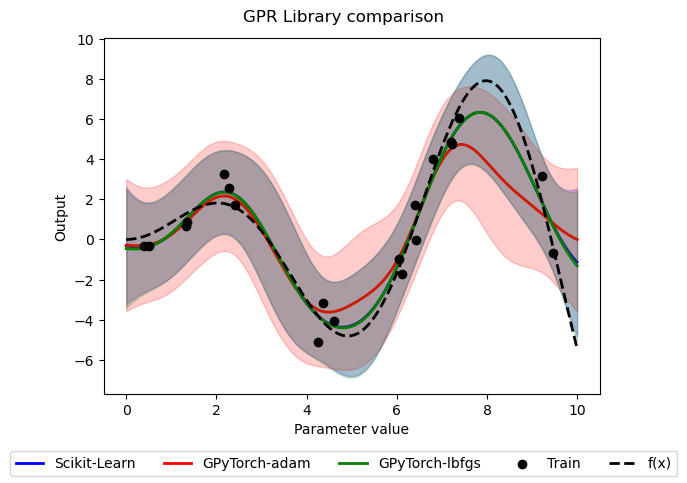

In [22]:
# Print all outputs together, in the same plot: 

fig, ax = plt.subplots()

# lims_gpr = np.array([math.floor(np.min(conf_int_lower)), math.ceil(np.max(conf_int_upper))])
    # Get limits
# lims_x = [math.floor(np.min(gpr_x)), math.ceil(np.max(gpr_x))]


# # Analytical limits
# lims_an = np.array([math.floor(np.min(analytical)), math.ceil(np.max(analytical))])
# # Max limit is defined by gpr and analytical
# lims_y = [np.min(np.array([lims_gpr[0], lims_an[0]])), np.max(np.array([lims_gpr[1], lims_an[1]]))]


# GPE data ---------------------------------------------------------------

# Scikit-learn
ax.plot(test_data, surrogate_prediction_skl, label="Scikit-Learn", linewidth=2, color='b', zorder=1)
ax.fill_between(test_data.ravel(), lower_skl, upper_skl, alpha=0.2, color='b')

# GPyTorch-adam
ax.plot(test_data, surrogate_prediction_adam, label="GPyTorch-adam", linewidth=2, color='r', zorder=1)
ax.fill_between(test_data.ravel(), lower_adam, upper_adam, alpha=0.2, color='r')

# GPyTorch-lbfgs
ax.plot(test_data, surrogate_prediction_lbfgs, label="GPyTorch-lbfgs", linewidth=2, color='g', zorder=1)
ax.fill_between(test_data.ravel(), lower_lbfgs, upper_lbfgs, alpha=0.2, color='g')

# Training points ---------------------------------------------------------------------

ax.scatter(train_data, train_y, label="Train", color="black", zorder=2)  # s=500
        
# Plot analytical data

ax.plot(test_data, reference_y, color='k', linewidth=2, linestyle="dashed", label="f(x)", zorder=1)

# Legends
handles, labels = ax.get_legend_handles_labels()

# Set limits --------------------------------------------------------------------------------
# ax.set_xlim(lims_x)
# ax.set_ylim([lims_y[0] - (0.5 * (lims_y[1] - lims_y[0])), lims_y[1] * 1.1])


ax.set_xlabel("Parameter value")
ax.set_ylabel("Output")
        
fig.suptitle(f'GPR Library comparison')
plt.subplots_adjust(top=0.92, bottom=0.18, wspace=0.3, hspace=0.3)


fig.legend(handles, labels, loc='lower center', ncol=5)
plt.show(block=False)


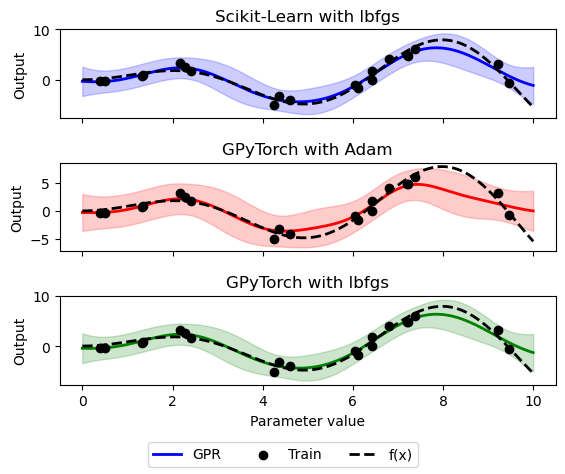

In [23]:
# Print all outputs together: in different subplots 

fig, ax = plt.subplots(3, 1, sharex=True)

# lims_gpr = np.array([math.floor(np.min(conf_int_lower)), math.ceil(np.max(conf_int_upper))])
    # Get limits
# lims_x = [math.floor(np.min(gpr_x)), math.ceil(np.max(gpr_x))]


# # Analytical limits
# lims_an = np.array([math.floor(np.min(analytical)), math.ceil(np.max(analytical))])
# # Max limit is defined by gpr and analytical
# lims_y = [np.min(np.array([lims_gpr[0], lims_an[0]])), np.max(np.array([lims_gpr[1], lims_an[1]]))]


# GPE data ---------------------------------------------------------------

# Scikit-learn
ax[0].plot(test_data, surrogate_prediction_skl, label="GPR", linewidth=2, color='b', zorder=1)
ax[0].fill_between(test_data.ravel(), lower_skl, upper_skl, alpha=0.2, color='b')
ax[0].set_title("Scikit-Learn with lbfgs")

# GPyTorch-adam
ax[1].plot(test_data, surrogate_prediction_adam, label="GPR", linewidth=2, color='r', zorder=1)
ax[1].fill_between(test_data.ravel(), lower_adam, upper_adam, alpha=0.2, color='r')
ax[1].set_title("GPyTorch with Adam")

# GPyTorch-lbfgs
ax[2].plot(test_data, surrogate_prediction_lbfgs, label="GPR", linewidth=2, color='g', zorder=1)
ax[2].fill_between(test_data.ravel(), lower_lbfgs, upper_lbfgs, alpha=0.2, color='g')
ax[2].set_title("GPyTorch with lbfgs")

# Training points ---------------------------------------------------------------------

ax[0].scatter(train_data, train_y, label="Train", color="black", zorder=2)  # s=500
ax[1].scatter(train_data, train_y, label="Train", color="black", zorder=2)  # s=500
ax[2].scatter(train_data, train_y, label="Train", color="black", zorder=2)  # s=500
        
# Plot analytical data

ax[0].plot(test_data, reference_y, color='k', linewidth=2, linestyle="dashed", label="f(x)", zorder=1)
ax[1].plot(test_data, reference_y, color='k', linewidth=2, linestyle="dashed", label="f(x)", zorder=1)
ax[2].plot(test_data, reference_y, color='k', linewidth=2, linestyle="dashed", label="f(x)", zorder=1)

# Legends
handles, labels = ax[0].get_legend_handles_labels()

# Set limits --------------------------------------------------------------------------------
# ax.set_xlim(lims_x)
# ax.set_ylim([lims_y[0] - (0.5 * (lims_y[1] - lims_y[0])), lims_y[1] * 1.1])


ax[2].set_xlabel("Parameter value")

ax[0].set_ylabel("Output")
ax[1].set_ylabel("Output")
ax[2].set_ylabel("Output")
        
plt.subplots_adjust(top=0.92, bottom=0.18, wspace=0.5, hspace=0.5)


fig.legend(handles, labels, loc='lower center', ncol=5)
plt.show(block=False)